<a href="https://colab.research.google.com/github/geryabra/SMP/blob/main/23_12_25_SMP_ALT_other_ver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Cell 1 — Imports + Paths + Cleanup

**The cleanup process**

In [23]:
import os
import glob

# Define paths (using globals to ensure they are the same as in the notebook)
OUTDIR = globals().get('OUTDIR', '/content/outputs')
BOOK1_PATH = globals().get('BOOK1_PATH', '/content/Book1.xlsx')
BOOK2_PATH = globals().get('BOOK2_PATH', '/content/Book2.xlsx')
AVAILABILITY_PATH = globals().get('AVAILABILITY_PATH', '/content/Availability.xlsx')

print(f"Cleaning directory: {OUTDIR}")

# Remove all .csv and .png files from the OUTDIR
for f in glob.glob(os.path.join(OUTDIR, '*.csv')):
    os.remove(f)
    print(f"Removed: {f}")
for f in glob.glob(os.path.join(OUTDIR, '*.png')):
    os.remove(f)
    print(f"Removed: {f}")

# Remove uploaded Excel files
for path in [BOOK1_PATH, BOOK2_PATH, AVAILABILITY_PATH]:
    if os.path.exists(path):
        os.remove(path)
        print(f"Removed: {path}")

# Handle files potentially renamed by Colab during upload
if os.path.exists('/content/Book1 (1).xlsx'):
    os.remove('/content/Book1 (1).xlsx')
    print("Removed: /content/Book1 (1).xlsx")
if os.path.exists('/content/Book2 (1).xlsx'):
    os.remove('/content/Book2 (1).xlsx')
    print("Removed: /content/Book2 (1).xlsx")
if os.path.exists('/content/Availability (1).xlsx'):
    os.remove('/content/Availability (1).xlsx')
    print("Removed: /content/Availability (1).xlsx")

print("Cleanup complete.")


Cleaning directory: /content/outputs
Removed: /content/outputs/Monthly_Anomalies_DA10.csv
Removed: /content/outputs/Merged_EffectiveBid_Anomalies.csv
Removed: /content/outputs/Monthly_Anomalies_DA1_DA9.csv
Removed: /content/Book1.xlsx
Removed: /content/Book2.xlsx
Removed: /content/Availability.xlsx
Cleanup complete.


In [1]:
# !pip -q install openpyxl  # לרוב אין צורך, אבל אפשר להשאיר

import os
import numpy as np
import pandas as pd

# ===== Paths / constants (matching your working notebook) =====
BOOK1_PATH = "/content/Book1.xlsx"          # upload as this name
BOOK2_PATH = "/content/Book2.xlsx"          # upload as this name
AVAILABILITY_PATH = "/content/Availability.xlsx"  # upload as this name

OUTDIR = "/content/outputs"
os.makedirs(OUTDIR, exist_ok=True)

OUT_CSV = os.path.join(OUTDIR, "Merged_EffectiveBid_Anomalies.csv")

FREQ_30MIN = "30min"
W1 = 48   # 1 day in 30-min slots



**Upload Book1 - SMP & Book2 - Suplier**

In [2]:
from google.colab import files

print("Upload Book1.xlsx and Book2.xlsx (exact names):")
uploaded = files.upload()  # choose your local Excel files

# Sanity: show what's uploaded
list(uploaded.keys())

Upload Book1.xlsx and Book2.xlsx (exact names):


Saving Book1.xlsx to Book1.xlsx
Saving Book2.xlsx to Book2.xlsx


['Book1.xlsx', 'Book2.xlsx']

**Upload Availability**

In [3]:
from google.colab import files
import os

print("Upload Availability.xlsx (exact name):")
uploaded = files.upload()  # choose your local Excel file

# Sanity: show what's uploaded
print(list(uploaded.keys()))

# Ensure the uploaded file is named Availability.xlsx
# If it was saved as 'Availability (1).xlsx' due to a previous file existing, rename it.
if 'Availability (1).xlsx' in uploaded:
    os.rename('/content/Availability (1).xlsx', '/content/Availability.xlsx')
    print("Renamed 'Availability (1).xlsx' to 'Availability.xlsx' to match AVAILABILITY_PATH.")
elif 'Availability.xlsx' not in uploaded:
    # This handles cases where the user might upload a file with a different name
    # It's better to explicitly check the uploaded keys and rename if necessary
    uploaded_filename = list(uploaded.keys())[0]
    if uploaded_filename != 'Availability.xlsx':
        os.rename(f'/content/{uploaded_filename}', '/content/Availability.xlsx')
        print(f"Renamed '{uploaded_filename}' to 'Availability.xlsx' to match AVAILABILITY_PATH.")

Upload Availability.xlsx (exact name):


Saving Availability.xlsx to Availability.xlsx
['Availability.xlsx']


##Cell 2 — Load + Normalize datetime

In [4]:
 for p in [BOOK1_PATH, BOOK2_PATH, AVAILABILITY_PATH]:
    if not os.path.exists(p):
        raise FileNotFoundError(f"Missing file: {p}\n"
                                f"Please upload it to Colab (Files pane) with the exact name.")

avail = pd.read_excel(AVAILABILITY_PATH)
book1 = pd.read_excel(BOOK1_PATH)
book2 = pd.read_excel(BOOK2_PATH)

print("Loaded:", avail.shape, book1.shape, book2.shape)
print("avail cols:", list(avail.columns))
print("book1 cols:", list(book1.columns)[:20], "...")
print("book2 cols:", list(book2.columns)[:20], "...")


Loaded: (17522, 3) (17518, 14) (17522, 33)
avail cols: ['Date', 'Time', 'Prod']
book1 cols: ['Date', 'Time', 'BidSell DA1', 'BidSell DA2', 'BidSell DA3', 'BidSell DA4', 'BidSell DA5', 'BidSell DA6', 'BidSell DA7', 'BidSell DA8', 'BidSell DA9', 'BidSell DA10', 'Avarege_DA1-DA10', 'Avarege_DA10'] ...
book2 cols: ['Date', 'Time', 'BidSell Low Limit1', 'BidSell Up Limit1', 'BidSell DA1', 'BidSell Low Limit2', 'BidSell Up Limit2', 'BidSell DA2', 'BidSell Low Limit3', 'BidSell Up Limit3', 'BidSell DA3', 'BidSell Low Limit4', 'BidSell Up Limit4', 'BidSell DA4', 'BidSell Low Limit5', 'BidSell Up Limit5', 'BidSell DA5', 'BidSell Low Limit6', 'BidSell Up Limit6', 'BidSell DA6'] ...


##Cell 3 — Normalize DateTime (Date + Time)

In [5]:
def build_datetime(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    if "DateTime" in df.columns:
        df["DateTime"] = pd.to_datetime(df["DateTime"])
        return df

    if "Date" not in df.columns or "Time" not in df.columns:
        raise ValueError("Expected columns: Date and Time (or a DateTime column).")

    df["Date"] = pd.to_datetime(df["Date"]).dt.date.astype(str)
    df["Time"] = pd.to_datetime(df["Time"].astype(str)).dt.strftime("%H:%M:%S")
    df["DateTime"] = pd.to_datetime(df["Date"] + " " + df["Time"])
    return df

avail = build_datetime(avail)
book1 = build_datetime(book1)
book2 = build_datetime(book2)

# keep only needed columns from availability
if "Prod" not in avail.columns:
    raise ValueError("Availability file must contain a 'Prod' column (actual production).")

avail = avail[["DateTime", "Prod"]].copy()


/tmp/ipython-input-3531311342.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Time"] = pd.to_datetime(df["Time"].astype(str)).dt.strftime("%H:%M:%S")
/tmp/ipython-input-3531311342.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Time"] = pd.to_datetime(df["Time"].astype(str)).dt.strftime("%H:%M:%S")
/tmp/ipython-input-3531311342.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Time"] = pd.to_datetime(df["Time"].astype(str)).dt.strftime("%H:%M:%S")


##Cell 4 — Build SMP column from Book1 + Merge All

In [6]:
# Build SMP: if there is SMP column use it, otherwise use BidSell DA1 as SMP
if "SMP" in book1.columns:
    book1_smp = book1[["DateTime", "SMP"]].copy()
else:
    if "BidSell DA1" not in book1.columns:
        raise ValueError("Book1 must contain 'SMP' or at least 'BidSell DA1' (used as SMP).")
    book1_smp = book1[["DateTime", "BidSell DA1"]].rename(columns={"BidSell DA1": "SMP"}).copy()

df = (
    avail.merge(book1_smp, on="DateTime", how="inner")
         .merge(book2, on="DateTime", how="inner", suffixes=("", "_b2"))
         .sort_values("DateTime")
         .reset_index(drop=True)
)

print("Merged shape:", df.shape)
df.head()


Merged shape: (17524, 36)


,DateTime,Prod,SMP,Date,Time,BidSell Low Limit1,BidSell Up Limit1,BidSell DA1,BidSell Low Limit2,BidSell Up Limit2,...,BidSell Low Limit8,BidSell Up Limit8,BidSell DA8,BidSell Low Limit9,BidSell Up Limit9,BidSell DA9,BidSell Low Limit10,BidSell Up Limit10,BidSell DA10,ממוצע בידים
0,2023-01-01 00:00:00,155.774185,108.35,2023-01-01,00:00:00,85.005,95.705,95.59,95.71,106.41,...,159.94,170.64,115.11,170.645,181.345,125.11,181.35,192.0,165.11,109.698
1,2023-01-01 00:30:00,148.962046,104.29,2023-01-01,00:30:00,85.005,95.705,95.59,95.71,106.41,...,159.94,170.64,115.11,170.645,181.345,125.11,181.35,192.0,165.11,109.698
2,2023-01-01 01:00:00,149.006561,103.15,2023-01-01,01:00:00,85.005,95.705,95.59,95.71,106.41,...,159.94,170.64,115.11,170.645,181.345,125.11,181.35,192.0,165.11,109.698
3,2023-01-01 01:30:00,148.968491,99.84,2023-01-01,01:30:00,85.005,95.705,95.59,95.71,106.41,...,159.94,170.64,115.11,170.645,181.345,125.11,181.35,192.0,165.11,109.698
4,2023-01-01 02:00:00,139.196562,97.10,2023-01-01,02:00:00,85.005,95.705,95.59,95.71,106.41,...,159.94,170.64,115.11,170.645,181.345,125.11,181.35,192.0,165.11,109.698


##Convert Prod + Book2 numeric columns to numbers

In [7]:
# --- FIX TYPES: convert Prod + Book2 numeric columns to numbers ---

# Prod
df["Prod"] = pd.to_numeric(df["Prod"], errors="coerce")

# Book2: limits + DA prices
for i in range(1, 11):
    for col in [f"BidSell Low Limit{i}", f"BidSell Up Limit{i}", f"BidSell DA{i}"]:
        if col in df.columns:
            # handle commas like "1,234"
            df[col] = (
                df[col]
                .astype(str)
                .str.replace(",", "", regex=False)
                .str.strip()
            )
            df[col] = pd.to_numeric(df[col], errors="coerce")

# quick sanity
print("Prod dtype:", df["Prod"].dtype)
print("Example dtypes:",
      {c: df[c].dtype for c in df.columns if c.startswith("BidSell Low Limit1") or c.startswith("BidSell Up Limit1") or c.startswith("BidSell DA1")})


Prod dtype: float64
Example dtypes: {'BidSell Low Limit1': dtype('float64'), 'BidSell Up Limit1': dtype('float64'), 'BidSell DA1': dtype('float64'), 'BidSell Low Limit10': dtype('float64'), 'BidSell Up Limit10': dtype('float64'), 'BidSell DA10': dtype('float64')}


##Cell 5 — Detect effective BidSell (DA1..DA10)  לפי ייצור בפועל


In [8]:
# =========================
# Cell 5 — Effective BidSell detection (KEEP ALL ROWS)
# =========================

def detect_effective_bid(row, n=10):
    """
    Returns:
        (BidSell label, BidSell price)
    Logic:
        - Identify BidSell ONLY if Prod > 0 and falls within [Low, Up)
        - Otherwise return (NaN, NaN)
    """
    prod = row["Prod"]

    if pd.isna(prod) or prod <= 0:
        return (np.nan, np.nan)

    for i in range(1, n + 1):
        low_col = f"BidSell Low Limit{i}"
        up_col  = f"BidSell Up Limit{i}"
        bid_col = f"BidSell DA{i}"

        if low_col not in row or up_col not in row or bid_col not in row:
            continue

        low = row[low_col]
        up  = row[up_col]

        if pd.isna(low) or pd.isna(up):
            continue

        # Range rule: low <= Prod < up
        if (prod >= low) and (prod < up):
            return (f"DA{i}", row[bid_col])

    return (np.nan, np.nan)


# --- Apply detection (NO filtering) ---
tmp = df.apply(lambda r: detect_effective_bid(r, n=10),
               axis=1, result_type="expand")

df["BidSell"] = tmp[0]
df["BidSellPrice"] = tmp[1]

# --- diff handling ---
# If no production / no BidSell → diff = 0 (per methodology)
df["BidSellPrice"] = pd.to_numeric(df["BidSellPrice"], errors="coerce")

df["diff"] = df["SMP"] - df["BidSellPrice"]
df.loc[df["BidSellPrice"].isna(), "diff"] = 0.0

df["abs_diff"] = df["diff"].abs()

print("Cell 5 completed")
print("Total rows kept:", len(df))
print("Rows with Prod == 0:", (df["Prod"] == 0).sum())
print("Rows with BidSell NaN:", df["BidSell"].isna().sum())


Cell 5 completed
Total rows kept: 17524
Rows with Prod == 0: 2255
Rows with BidSell NaN: 3770


##Cell 6 — diff + Peak/Offpeak + Rolling z + Anomalies

In [9]:
# =========================
# Cell 6 — Anomaly detection (FULL DATA, incl. no-production)
# =========================

# Peak definition: 17:00–23:00
hour = df["DateTime"].dt.hour
df["is_peak"] = (hour >= 17) & (hour < 23)
df["period"] = np.where(df["is_peak"], "peak", "offpeak")

# Methodology parameters
WINDOW = 48
MIN_PEAK = 6     # ≥50% of peak half-hours
MIN_OFF  = 18    # ≥50% of off-peak half-hours
EPS = 1e-9


def add_anomaly_metrics(g: pd.DataFrame, min_periods: int) -> pd.DataFrame:
    g = g.sort_values("DateTime").copy()

    # μ_t = rolling mean of |diff|
    g["mu_absdiff"] = g["abs_diff"].rolling(
        window=WINDOW,
        min_periods=min_periods
    ).mean()

    # σ_t = rolling std of diff
    g["sigma_diff"] = g["diff"].rolling(
        window=WINDOW,
        min_periods=min_periods
    ).std()

    # z_t = (|diff| − μ) / (σ + ε)
    g["z"] = (g["abs_diff"] - g["mu_absdiff"]) / (g["sigma_diff"].fillna(0) + EPS)

    # anomaly flag
    g["is_anomaly"] = g["z"].abs() > 2

    return g


peak_part = add_anomaly_metrics(
    df[df["period"] == "peak"], min_periods=MIN_PEAK
)

off_part = add_anomaly_metrics(
    df[df["period"] == "offpeak"], min_periods=MIN_OFF
)

out = (
    pd.concat([peak_part, off_part])
      .sort_values("DateTime")
      .reset_index(drop=True)
)

print("Cell 6 completed")
print("Final rows:", len(out))
print("Anomalies:", out["is_anomaly"].sum())


Cell 6 completed
Final rows: 17524
Anomalies: 734


##Cell 7 — Export one unified CSV

In [10]:
export_cols = [
    "DateTime","Prod","SMP",
    "BidSell","BidSellPrice",
    "diff","abs_diff",
    "period",
    "mu_absdiff","sigma_diff","z","is_anomaly",
]

out[export_cols].to_csv(OUT_CSV, index=False, encoding="utf-8-sig")
print("Saved:", OUT_CSV)
out[export_cols].head()


Saved: /content/outputs/Merged_EffectiveBid_Anomalies.csv


,DateTime,Prod,SMP,BidSell,BidSellPrice,diff,abs_diff,period,mu_absdiff,sigma_diff,z,is_anomaly
0,2023-01-01 00:00:00,155.774185,108.35,DA7,112.11,-3.76,3.76,offpeak,NaN,NaN,NaN,False
1,2023-01-01 00:30:00,148.962046,104.29,DA6,99.59,4.70,4.70,offpeak,NaN,NaN,NaN,False
2,2023-01-01 01:00:00,149.006561,103.15,DA6,99.59,3.56,3.56,offpeak,NaN,NaN,NaN,False
3,2023-01-01 01:30:00,148.968491,99.84,DA6,99.59,0.25,0.25,offpeak,NaN,NaN,NaN,False
4,2023-01-01 02:00:00,139.196562,97.10,DA6,99.59,-2.49,2.49,offpeak,NaN,NaN,NaN,False


##Cell 8  - Cell — Monthly anomaly tables + CSV export (DA1–DA9 & DA10)


In [11]:
import pandas as pd
import numpy as np
import os

# =========================
# Monthly anomaly summary tables + CSV export (ORDERED ROWS)
# =========================

OUTDIR = "/content/outputs"
os.makedirs(OUTDIR, exist_ok=True)

# --- Safety checks ---
required_cols = {"DateTime", "BidSell", "period", "diff", "is_anomaly"}
missing = required_cols - set(out.columns)
if missing:
    raise ValueError(f"Missing columns in 'out': {missing}")

df = out.copy()
df["month"] = df["DateTime"].dt.to_period("M").astype(str)

# Only executed bids (Prod>0 matched to a DA)
df = df[df["BidSell"].notna()].copy()

df["is_anomaly_int"] = df["is_anomaly"].astype(int)

def build_table(df_sub: pd.DataFrame, title: str) -> pd.DataFrame:
    """
    Columns: months (YYYY-MM)
    Rows (ORDERED):
      peak_num_anomalies
      offpeak_num_anomalies
      peak_ratio_anomalies
      offpeak_ratio_anomalies
      peak_mean_diff
      offpeak_mean_diff
    """
    agg = (
        df_sub
        .groupby(["period", "month"], as_index=False)
        .agg(
            mean_diff=("diff", "mean"),
            num_anomalies=("is_anomaly_int", "sum"),
            n=("diff", "size"),
        )
    )
    agg["ratio_anomalies"] = agg["num_anomalies"] / agg["n"]

    def pivot(metric):
        return agg.pivot(index="period", columns="month", values=metric)

    mean_w = pivot("mean_diff")
    num_w  = pivot("num_anomalies")
    rat_w  = pivot("ratio_anomalies")

    rows = [
        num_w.loc["peak"]      if "peak" in num_w.index else pd.Series(dtype=float),
        num_w.loc["offpeak"]   if "offpeak" in num_w.index else pd.Series(dtype=float),
        rat_w.loc["peak"]      if "peak" in rat_w.index else pd.Series(dtype=float),
        rat_w.loc["offpeak"]   if "offpeak" in rat_w.index else pd.Series(dtype=float),
        mean_w.loc["peak"]     if "peak" in mean_w.index else pd.Series(dtype=float),
        mean_w.loc["offpeak"]  if "offpeak" in mean_w.index else pd.Series(dtype=float),
    ]

    index = [
        "peak_num_anomalies",
        "offpeak_num_anomalies",
        "peak_ratio_anomalies",
        "offpeak_ratio_anomalies",
        "peak_mean_diff",
        "offpeak_mean_diff",
    ]

    table = pd.DataFrame(rows, index=index)
    table = table.reindex(sorted(table.columns), axis=1)
    table.attrs["title"] = title
    return table

# --- Split datasets ---
da1_9 = df[df["BidSell"].isin([f"DA{i}" for i in range(1, 10)])].copy()
da10  = df[df["BidSell"] == "DA10"].copy()

# --- Build tables ---
table_da1_9 = build_table(da1_9, "DA1-DA9 Monthly Anomalies (Executed Bids Only)")
table_da10  = build_table(da10,  "DA10 Monthly Anomalies (Executed Bids Only)")

# --- Save to CSV ---
path_da1_9 = os.path.join(OUTDIR, "Monthly_Anomalies_DA1_DA9.csv")
path_da10  = os.path.join(OUTDIR, "Monthly_Anomalies_DA10.csv")

table_da1_9.to_csv(path_da1_9, encoding="utf-8-sig")
table_da10.to_csv(path_da10,  encoding="utf-8-sig")

print("Saved CSV files:")
print(path_da1_9)
print(path_da10)

# --- Display ---
print(table_da1_9.attrs["title"])
display(table_da1_9)

print(table_da10.attrs["title"])
display(table_da10)


Saved CSV files:
/content/outputs/Monthly_Anomalies_DA1_DA9.csv
/content/outputs/Monthly_Anomalies_DA10.csv
DA1-DA9 Monthly Anomalies (Executed Bids Only)


month,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08,2023-09,2023-10,2023-11,2023-12
peak_num_anomalies,17.000000,3.000000,35.000000,5.000000,4.000000,11.000000,12.000000,8.000000,6.000000,15.000000,0.000000,20.000000
offpeak_num_anomalies,48.000000,37.000000,43.000000,49.000000,28.000000,22.000000,0.000000,2.000000,15.000000,38.000000,22.000000,43.000000
peak_ratio_anomalies,0.062500,0.024793,0.158371,0.021368,0.015152,0.036184,0.129032,0.112676,0.095238,0.059055,0.000000,0.067340
offpeak_ratio_anomalies,0.059553,0.053468,0.079044,0.070809,0.035176,0.028314,0.000000,0.004454,0.028958,0.044444,0.041276,0.055699
peak_mean_diff,-7.987684,-5.808926,-24.722127,-39.337436,-34.787121,-29.511743,-18.975054,-10.114085,-8.097778,-5.873583,3.772047,-39.795993
offpeak_mean_diff,-5.534702,-5.905145,3.551526,-2.345983,2.278530,4.112304,8.667232,1.479621,-5.129151,-2.696058,12.458105,-25.305661


DA10 Monthly Anomalies (Executed Bids Only)


month,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08,2023-09,2023-10,2023-11,2023-12
peak_num_anomalies,3.000000,4.000000,1.000000,2.000000,2.000000,2.000000,13.000000,13.000000,13.000000,6.000000,1.000,6.000000
offpeak_num_anomalies,11.000000,18.000000,8.000000,21.000000,28.000000,29.000000,5.000000,13.000000,15.000000,13.000000,1.000,6.000000
peak_ratio_anomalies,0.042857,0.024845,0.035714,0.055556,0.064516,0.111111,0.048148,0.043333,0.045139,0.082192,0.100,0.240000
offpeak_ratio_anomalies,0.733333,0.428571,0.258065,0.500000,0.482759,0.237705,0.008224,0.021104,0.029880,0.130000,0.050,0.260870
peak_mean_diff,-22.523143,-23.245466,-26.007143,-45.426944,-50.509677,-39.194444,-24.887444,-15.095600,-13.052500,-12.745342,28.845,-128.008000
offpeak_mean_diff,-52.841333,-38.841429,-52.059032,-61.234286,-52.663621,-50.035246,-35.511579,-24.956461,-33.540697,-26.121000,19.464,-134.458696


##Cell — Violin+Box for diff + n= (# anomalies)

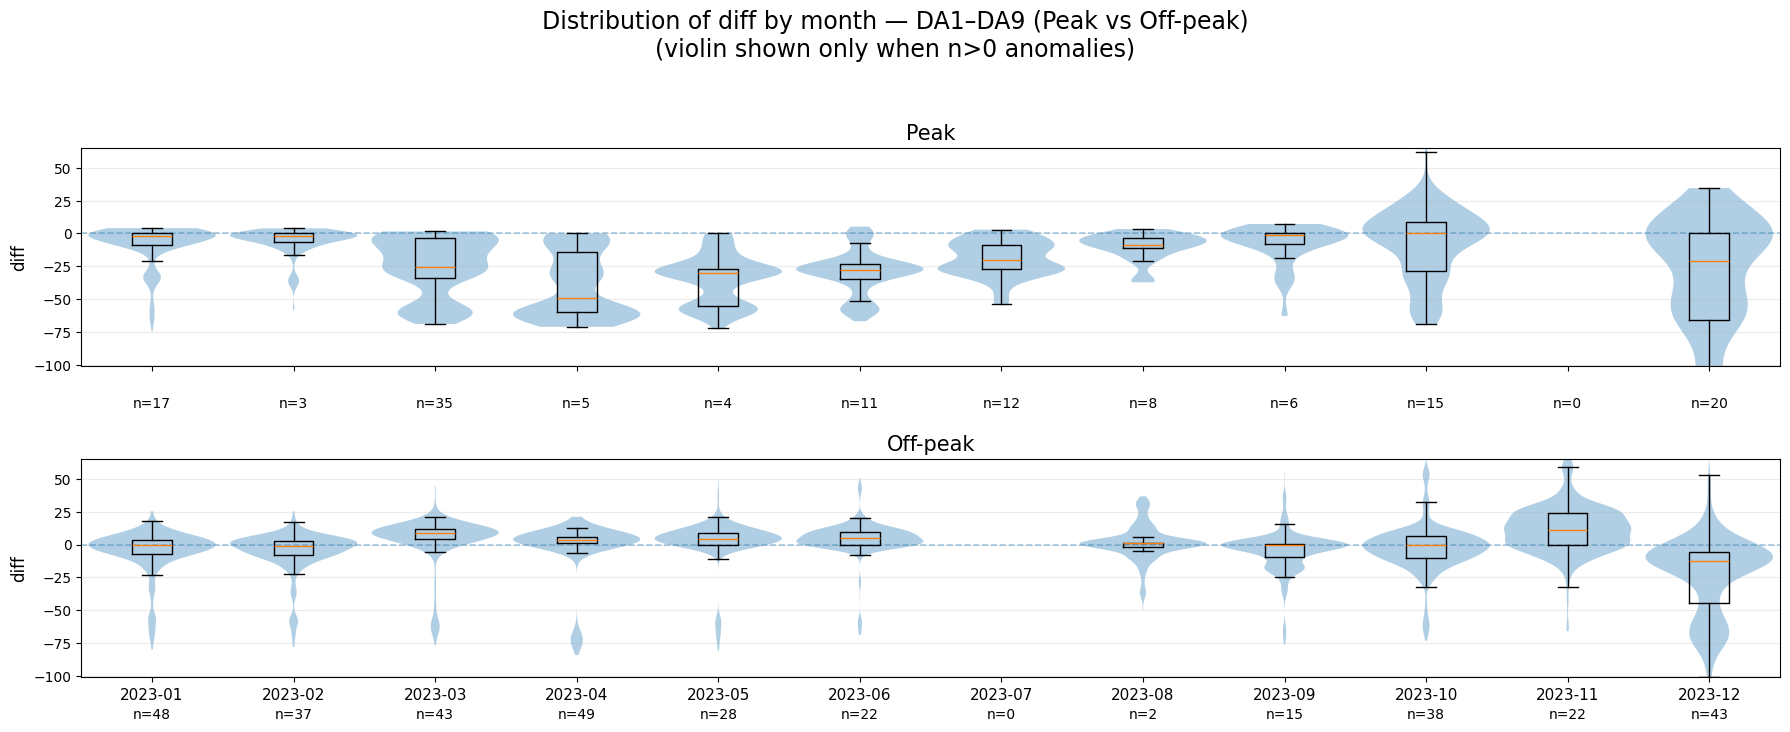

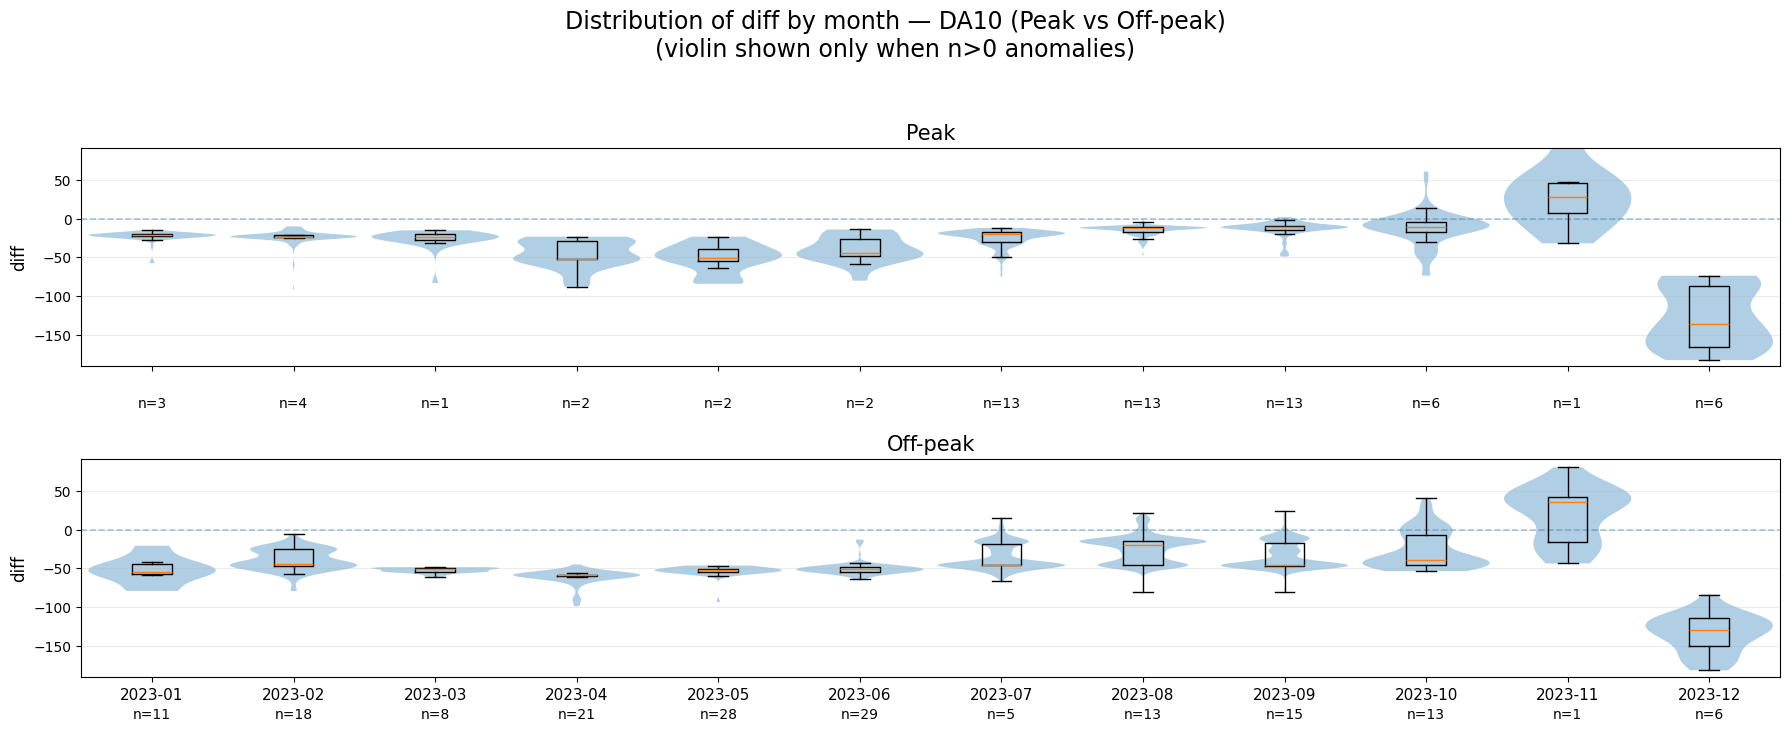

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =========================
# Two separate figures:
# 1) DA1-DA9
# 2) DA10
# Each figure: 2 panels (Peak / Off-peak)
# Violin+box drawn only when n_anom > 0 for that month & period
# =========================

BASE = out.copy()
BASE = BASE[BASE["BidSell"].notna()].copy()
BASE["month"] = BASE["DateTime"].dt.to_period("M").astype(str)

MONTHS = sorted(BASE["month"].unique())
XPOS_ALL = np.arange(1, len(MONTHS) + 1)

def plot_peak_off_by_month(
    df_in: pd.DataFrame,
    fig_title: str,
    pad_factor: float = 0.18,
    save_path: str | None = None
):

    df = df_in.copy()

    # collect arrays + anomaly counts for each period
    def collect(period):
        data = []
        n_anom = []
        for m in MONTHS:
            d = df[(df["month"] == m) & (df["period"] == period)]
            arr = d["diff"].dropna().astype(float).values
            data.append(arr)
            n_anom.append(int(d["is_anomaly"].sum()))
        return data, n_anom

    data_peak, n_peak = collect("peak")
    data_off,  n_off  = collect("offpeak")

    # Y limits using robust percentiles (computed per figure)
    all_diff = df["diff"].dropna().astype(float).values
    if len(all_diff) == 0:
        print(f"Skipping '{fig_title}' — no diff data.")
        return

    p_lo, p_hi = np.percentile(all_diff, [1, 99])
    pad = pad_factor * (p_hi - p_lo if p_hi > p_lo else 1.0)
    ymin, ymax = p_lo - pad, p_hi + pad

    fig, axes = plt.subplots(2, 1, figsize=(18, 8), sharex=True, sharey=True)

    for ax, data, n_anom, subtitle in [
        (axes[0], data_peak, n_peak, "Peak"),
        (axes[1], data_off,  n_off,  "Off-peak"),
    ]:
        ax.axhline(0, linestyle="--", linewidth=1.2, alpha=0.4)

        # draw only months where n_anom > 0 and there is data
        keep_idx = [i for i, (arr, n) in enumerate(zip(data, n_anom)) if (n > 0 and len(arr) > 0)]
        keep_pos = [XPOS_ALL[i] for i in keep_idx]
        keep_data = [data[i] for i in keep_idx]

        if len(keep_data) > 0:
            vp = ax.violinplot(
                keep_data,
                positions=keep_pos,
                widths=0.9,
                showextrema=False
            )
            for b in vp["bodies"]:
                b.set_alpha(0.35)

            ax.boxplot(
                keep_data,
                positions=keep_pos,
                widths=0.28,
                showfliers=False
            )

        ax.set_title(subtitle, fontsize=15)
        ax.grid(True, axis="y", alpha=0.25)
        ax.set_ylim(ymin, ymax)

        # n labels below axis for ALL months
        for i, n in enumerate(n_anom, start=1):
            ax.text(
                i, -0.14, f"n={n}",
                transform=ax.get_xaxis_transform(),
                ha="center", va="top",
                fontsize=10,
                clip_on=False
            )

    axes[1].set_xticks(XPOS_ALL)
    axes[1].set_xticklabels(MONTHS, fontsize=11)

    axes[0].set_ylabel("diff", fontsize=12)
    axes[1].set_ylabel("diff", fontsize=12)

    fig.suptitle(
        fig_title + "\n(violin shown only when n>0 anomalies)",
        fontsize=17
    )

    plt.tight_layout(rect=[0, 0.06, 1, 0.94])
    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")

    plt.show()





# -------------------------
# Figure 1: DA1-DA9
# -------------------------
df_1_9 = BASE[BASE["BidSell"].isin([f"DA{i}" for i in range(1, 10)])].copy()
plot_peak_off_by_month(df_1_9, "Distribution of diff by month — DA1–DA9 (Peak vs Off-peak)")

# -------------------------
# Figure 2: DA10
# -------------------------
df_10 = BASE[BASE["BidSell"] == "DA10"].copy()
plot_peak_off_by_month(df_10, "Distribution of diff by month — DA10 (Peak vs Off-peak)", pad_factor=0.6)

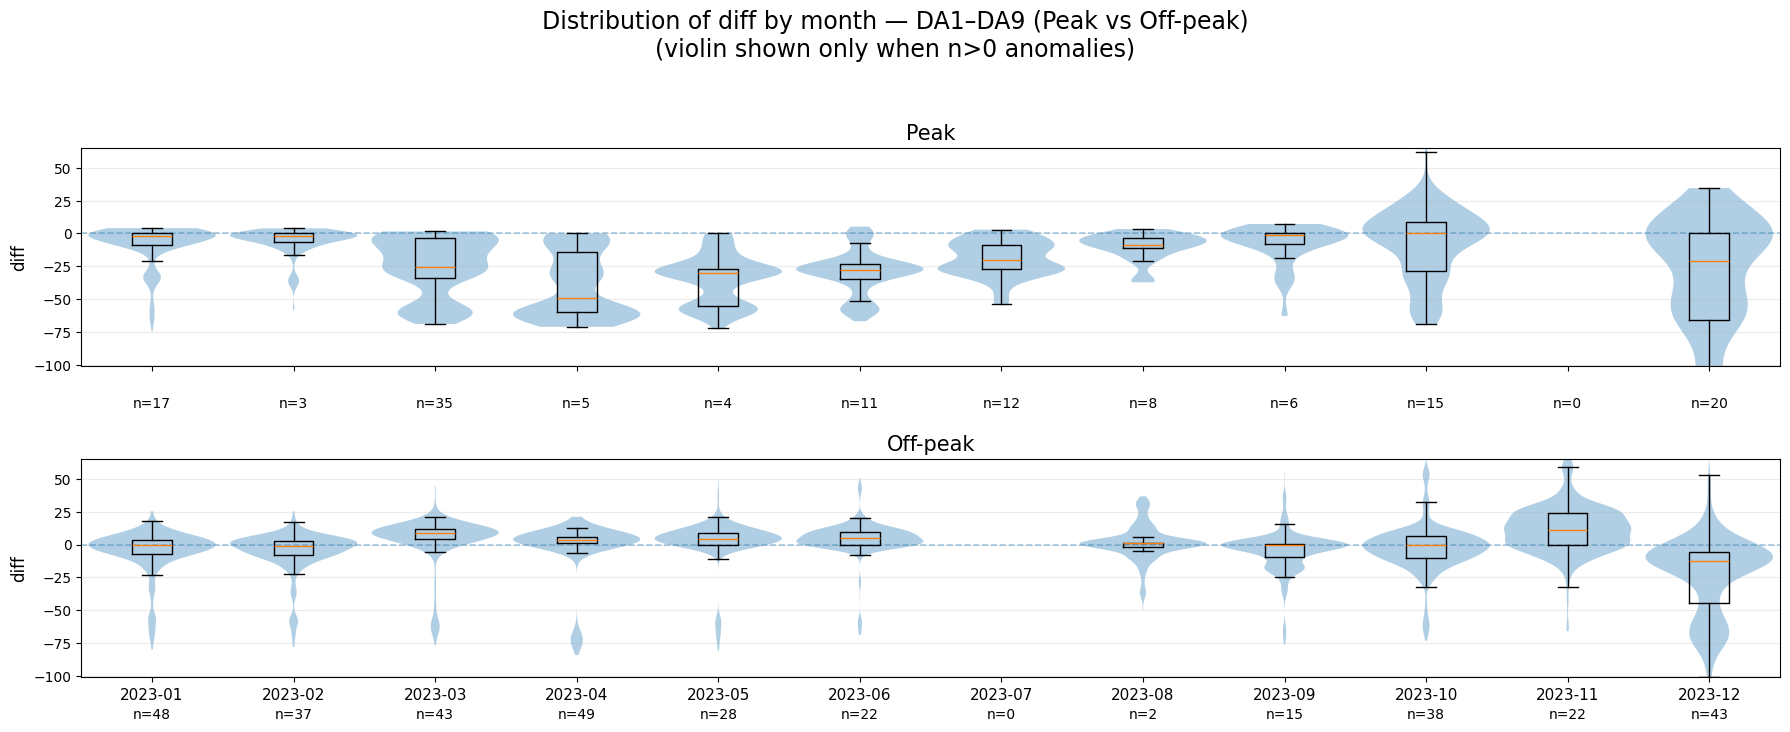

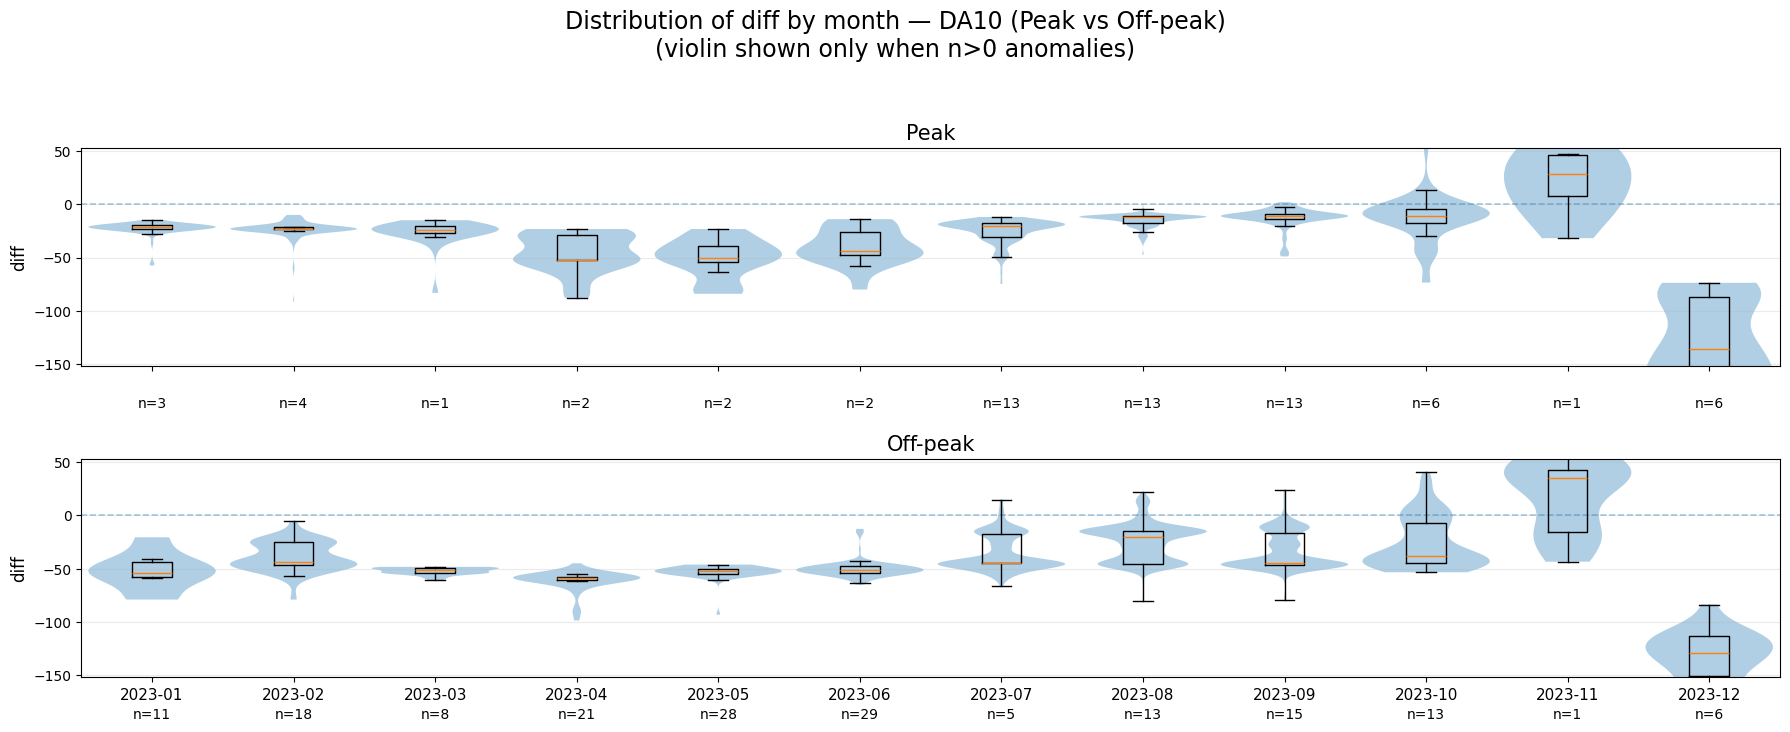

In [23]:
OUTDIR = "/content/outputs"

plot_peak_off_by_month(
    df_1_9,
    "Distribution of diff by month — DA1–DA9 (Peak vs Off-peak)",
    pad_factor=0.18,
    save_path=f"{OUTDIR}/violin_diff_DA1_9_peak_offpeak.png"
)

plot_peak_off_by_month(
    df_10,
    "Distribution of diff by month — DA10 (Peak vs Off-peak)",
    pad_factor=0.30,
    save_path=f"{OUTDIR}/violin_diff_DA10_peak_offpeak.png"
)

Using columns:
  DateTime: DateTime
  BidSell: BidSell
  period: period
  SMP: SMP
  BidSellPrice: BidSellPrice

Sanity checks:
  price_diff describe:
 count    13754.000000
mean       -12.464155
std         26.648955
min       -182.940000
25%        -25.275000
50%         -4.880000
75%          3.777500
max        113.390000
Name: price_diff, dtype: float64
  period value counts:
 period
offpeak    10079
peak        3675
Name: count, dtype: int64

Monthly means (DA1–DA9):
period  offpeak   peak
month                 
1         -5.53  -7.99
2         -5.91  -5.81
3          3.55 -24.72
4         -2.35 -39.34
5          2.28 -34.79
6          4.11 -29.51
7          8.67 -18.98
8          1.48 -10.11
9         -5.13  -8.10
10        -2.70  -5.87
11        12.46   3.77
12       -25.31 -39.80

Monthly means (DA10):
period  offpeak    peak
month                  
1        -52.84  -22.52
2        -38.84  -23.25
3        -52.06  -26.01
4        -61.23  -45.43
5        -52.66  -50.51
6        

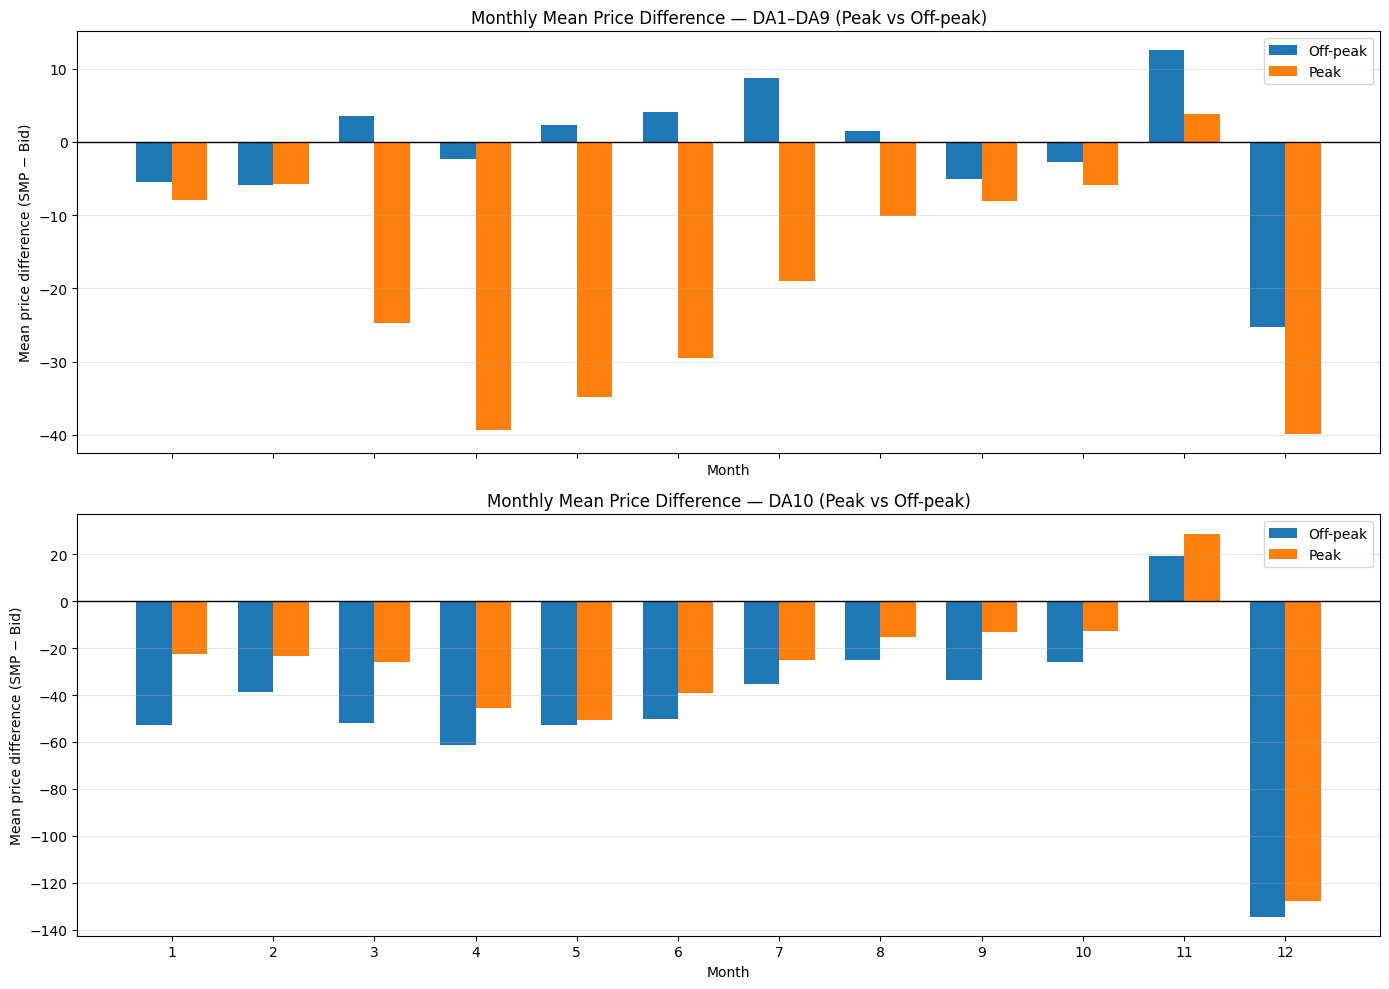

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

# ----------------------------
# CONFIG
# ----------------------------
# Choose the direction you want:
#   "SMP_MINUS_BID"  => diff = SMP - BidSellPrice   (usually what people expect)
#   "BID_MINUS_SMP"  => diff = BidSellPrice - SMP   (what you had before)
DIFF_MODE = "SMP_MINUS_BID"

# If you want to run from the merged CSV instead of `out`, set USE_CSV = True
USE_CSV = False
CSV_PATH = "/mnt/data/Merged_EffectiveBid_Anomalies (2).csv"

# ----------------------------
# LOAD
# ----------------------------
df = pd.read_csv(CSV_PATH) if USE_CSV else out.copy()

# ----------------------------
# Detect columns robustly
# ----------------------------
cols = list(df.columns)

def pick_col(preferred_list, regex_fallback):
    for c in preferred_list:
        if c in df.columns:
            return c
    cand = [c for c in df.columns if re.search(regex_fallback, c, flags=re.IGNORECASE)]
    return cand[0] if cand else None

dt_col = pick_col(["DateTime", "Datetime", "date_time", "TimeStamp"], r"(date|time)")
bid_col = pick_col(["BidSell", "Bid", "BidSellDA", "BidSell_DA"], r"\bbid")
period_col = pick_col(["period", "Period", "PeakOffpeak", "peak_offpeak"], r"(peak|off)")
smp_col = pick_col(["SMP", "Smp", "smp_price"], r"\bsmp\b")
bid_price_col = pick_col(["BidSellPrices", "BidSellPrice", "BidSell_Price", "BidPrice"], r"(bid).*?(price)")

missing = [("DateTime", dt_col), ("BidSell", bid_col), ("period", period_col), ("SMP", smp_col), ("BidSellPrice", bid_price_col)]
missing = [name for name, col in missing if col is None]
if missing:
    raise KeyError(f"Missing required columns: {missing}. Available columns: {cols}")

print("Using columns:")
print("  DateTime:", dt_col)
print("  BidSell:", bid_col)
print("  period:", period_col)
print("  SMP:", smp_col)
print("  BidSellPrice:", bid_price_col)

# ----------------------------
# Prep types + normalize period
# ----------------------------
df = df.copy()
df[dt_col] = pd.to_datetime(df[dt_col])
df["month"] = df[dt_col].dt.month

df[smp_col] = pd.to_numeric(df[smp_col], errors="coerce")
df[bid_price_col] = pd.to_numeric(df[bid_price_col], errors="coerce")

df[period_col] = df[period_col].astype(str).str.strip().str.lower()
df[period_col] = df[period_col].replace({
    "off-peak": "offpeak",
    "off_peak": "offpeak",
    "off peak": "offpeak",
    "off": "offpeak",
    "peak hours": "peak",
})

# Keep only rows with both prices present
df = df.dropna(subset=[smp_col, bid_price_col])

# ----------------------------
# Compute PER-ROW difference first (important!)
# ----------------------------
if DIFF_MODE == "SMP_MINUS_BID":
    df["price_diff"] = df[smp_col] - df[bid_price_col]
    ylab = "Mean price difference (SMP − Bid)"
elif DIFF_MODE == "BID_MINUS_SMP":
    df["price_diff"] = df[bid_price_col] - df[smp_col]
    ylab = "Mean price difference (Bid − SMP)"
else:
    raise ValueError("DIFF_MODE must be 'SMP_MINUS_BID' or 'BID_MINUS_SMP'")

# ----------------------------
# Sanity checks (so the plot matches the data)
# ----------------------------
print("\nSanity checks:")
print("  price_diff describe:\n", df["price_diff"].describe())
print("  period value counts:\n", df[period_col].value_counts(dropna=False).head(10))

# ----------------------------
# Monthly mean helper
# ----------------------------
def monthly_mean(dsub):
    # Mean of per-row diffs, grouped by month & period
    m = (
        dsub.groupby(["month", period_col])["price_diff"]
            .mean()
            .unstack(period_col)
            .reindex(range(1, 13))
    )
    # Ensure both columns exist
    for c in ["peak", "offpeak"]:
        if c not in m.columns:
            m[c] = np.nan
    return m[["offpeak", "peak"]]

# ----------------------------
# Split DA groups
# ----------------------------
da_1_9 = [f"DA{i}" for i in range(1, 10)]
df_1_9 = df[df[bid_col].isin(da_1_9)]
df_10  = df[df[bid_col] == "DA10"]

m_1_9 = monthly_mean(df_1_9)
m_10  = monthly_mean(df_10)

# Extra sanity: show the monthly table values
print("\nMonthly means (DA1–DA9):")
print(m_1_9.round(2))
print("\nMonthly means (DA10):")
print(m_10.round(2))

# ----------------------------
# Plot helper
# ----------------------------
def plot_monthly_bars(ax, data, title):
    months = np.arange(1, 13)
    width = 0.35

    ax.bar(months - width/2, data["offpeak"], width, label="Off-peak")
    ax.bar(months + width/2, data["peak"], width, label="Peak")

    ax.axhline(0, color="black", linewidth=1)
    ax.set_xticks(months)
    ax.set_xlabel("Month")
    ax.set_ylabel(ylab)
    ax.set_title(title)
    ax.grid(True, axis="y", alpha=0.3)
    ax.legend()

# ----------------------------
# Plot: two panels
# ----------------------------
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

plot_monthly_bars(axes[0], m_1_9, "Monthly Mean Price Difference — DA1–DA9 (Peak vs Off-peak)")
plot_monthly_bars(axes[1], m_10,  "Monthly Mean Price Difference — DA10 (Peak vs Off-peak)")

plt.tight_layout()
plt.show()


Using columns:
  DateTime: DateTime
  BidSell: BidSell
  diff: diff


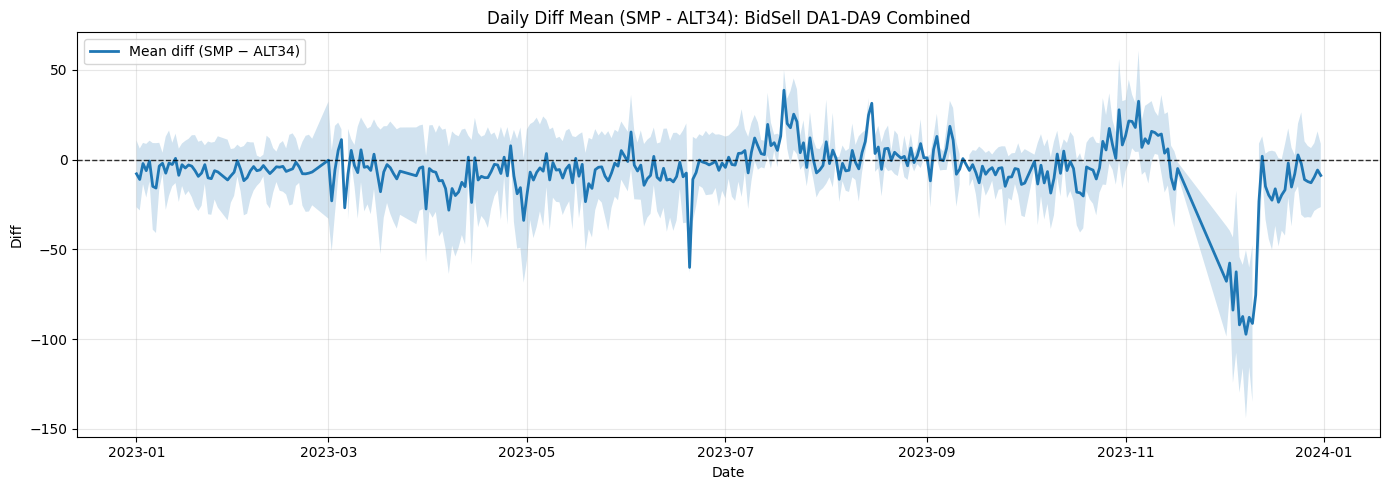

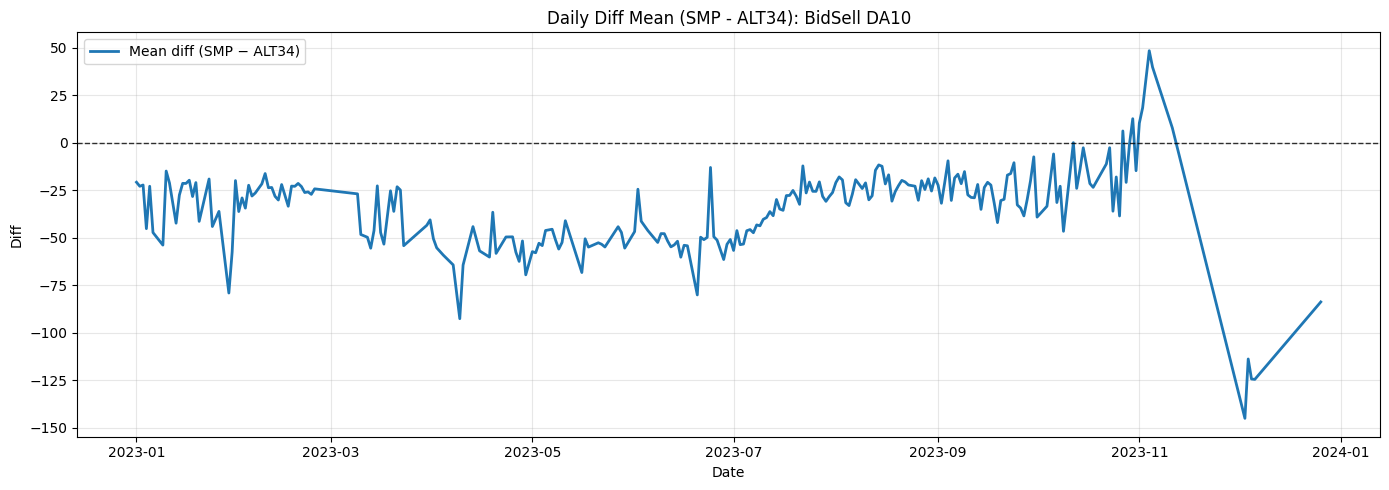

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

# =========================
# Two plots like screenshot:
# 1) DA1–DA9 combined: daily mean diff + shaded std band
# 2) DA10: daily mean diff
# diff is SMP - ALT34 (or generally SMP - BidSell price column)
# =========================

# ---- choose source dataframe ----
df = out.copy()

# ---- detect columns ----
cols = list(df.columns)

def pick_col(preferred, regex_fallback):
    for c in preferred:
        if c in df.columns:
            return c
    cand = [c for c in df.columns if re.search(regex_fallback, c, flags=re.IGNORECASE)]
    return cand[0] if cand else None

dt_col = pick_col(["DateTime", "Datetime", "date_time", "timestamp"], r"(date|time)")
bid_col = pick_col(["BidSell", "Bid", "BidSellDA"], r"\bbid")
diff_col = "diff" if "diff" in df.columns else None
smp_col = pick_col(["SMP", "Smp"], r"\bsmp\b")
bid_price_col = pick_col(["BidSellPrices", "BidSellPrice", "BidSell_Price", "ALT34"], r"(bid).*?(price)|alt34")

missing = []
if dt_col is None: missing.append("DateTime")
if bid_col is None: missing.append("BidSell")
if diff_col is None and (smp_col is None or bid_price_col is None):
    missing.append("diff OR (SMP and BidSellPrices/ALT34)")
if missing:
    raise KeyError(f"Missing required columns: {missing}. Available: {cols}")

print("Using columns:")
print("  DateTime:", dt_col)
print("  BidSell:", bid_col)
print("  diff:", diff_col)
if diff_col is None:
    print("  SMP:", smp_col)
    print("  BidSell/ALT price:", bid_price_col)

# ---- prep ----
df = df.copy()
df[dt_col] = pd.to_datetime(df[dt_col])
df["date"] = df[dt_col].dt.floor("D")

# compute diff if not present
if diff_col is None:
    df[smp_col] = pd.to_numeric(df[smp_col], errors="coerce")
    df[bid_price_col] = pd.to_numeric(df[bid_price_col], errors="coerce")
    df["diff"] = df[smp_col] - df[bid_price_col]
else:
    df["diff"] = pd.to_numeric(df[diff_col], errors="coerce")

# keep only rows with BidSell and diff
df = df[df[bid_col].notna()].dropna(subset=["diff"]).copy()

# -------------------------
# Helper: daily mean & std
# -------------------------
def daily_stats(dsub):
    g = dsub.groupby("date")["diff"]
    out_stats = pd.DataFrame({
        "mean": g.mean(),
        "std": g.std()
    }).reset_index()
    return out_stats.sort_values("date")

# -------------------------
# Split data
# -------------------------
da_1_9 = [f"DA{i}" for i in range(1, 10)]
df_1_9 = df[df[bid_col].isin(da_1_9)]
df_10  = df[df[bid_col] == "DA10"]

s_1_9 = daily_stats(df_1_9)
s_10  = daily_stats(df_10)

# -------------------------
# Plot 1: DA1–DA9 combined + band
# -------------------------
fig, ax = plt.subplots(figsize=(14, 5))

ax.plot(s_1_9["date"], s_1_9["mean"], label="Mean diff (SMP − ALT34)", linewidth=2)

# shaded band (±1 std). If std is NaN (single point day), band will be skipped automatically
ax.fill_between(
    s_1_9["date"],
    (s_1_9["mean"] - s_1_9["std"]),
    (s_1_9["mean"] + s_1_9["std"]),
    alpha=0.2
)

ax.axhline(0, color="black", linestyle="--", linewidth=1, alpha=0.8)

ax.set_title("Daily Diff Mean (SMP - ALT34): BidSell DA1-DA9 Combined")
ax.set_xlabel("Date")
ax.set_ylabel("Diff")
ax.grid(True, alpha=0.3)
ax.legend(loc="upper left")

plt.tight_layout()
plt.show()

# -------------------------
# Plot 2: DA10 only (no band)
# -------------------------
fig, ax = plt.subplots(figsize=(14, 5))

ax.plot(s_10["date"], s_10["mean"], label="Mean diff (SMP − ALT34)", linewidth=2)
ax.axhline(0, color="black", linestyle="--", linewidth=1, alpha=0.8)
ax.set_title("Daily Diff Mean (SMP - ALT34): BidSell DA10")
ax.set_xlabel("Date")
ax.set_ylabel("Diff")
ax.grid(True, alpha=0.3)
ax.legend(loc="upper left")

plt.tight_layout()
plt.show()


Using columns:
  DateTime: DateTime
  BidSell: BidSell
  diff: diff
Plots saved to: /content/outputs/intraday_diff_DA1_9_seasonal.png


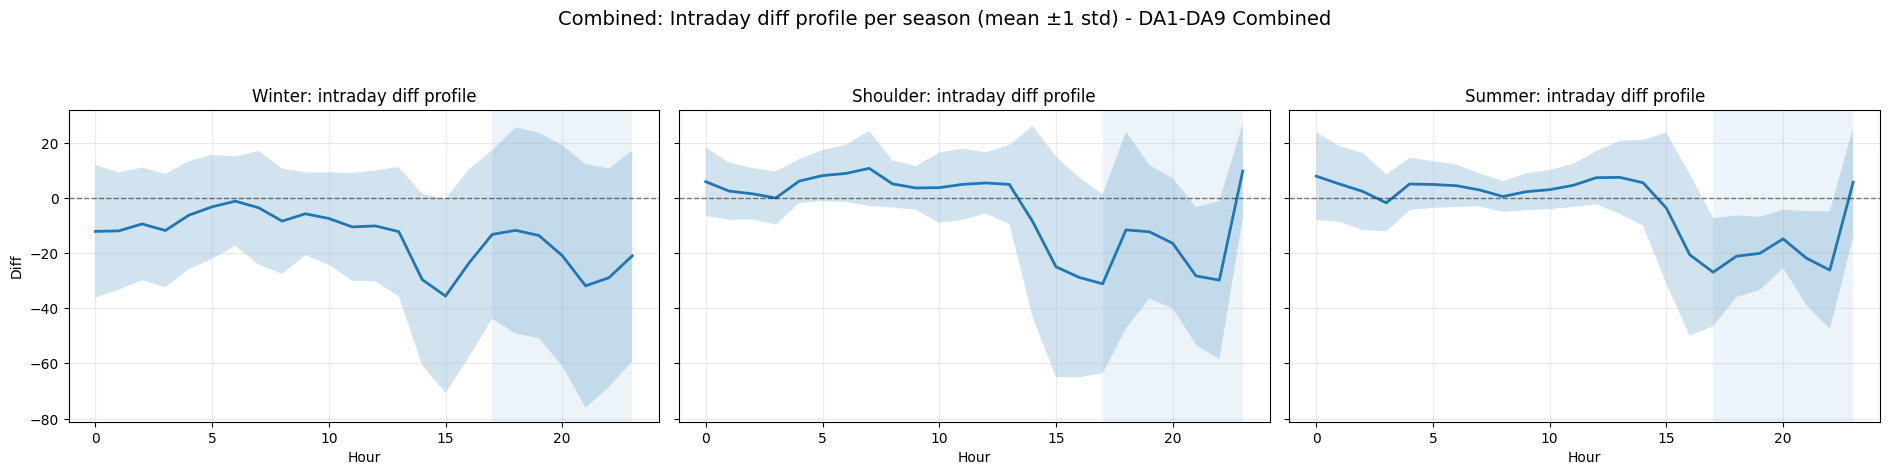

Plots saved to: /content/outputs/intraday_diff_DA10_seasonal.png


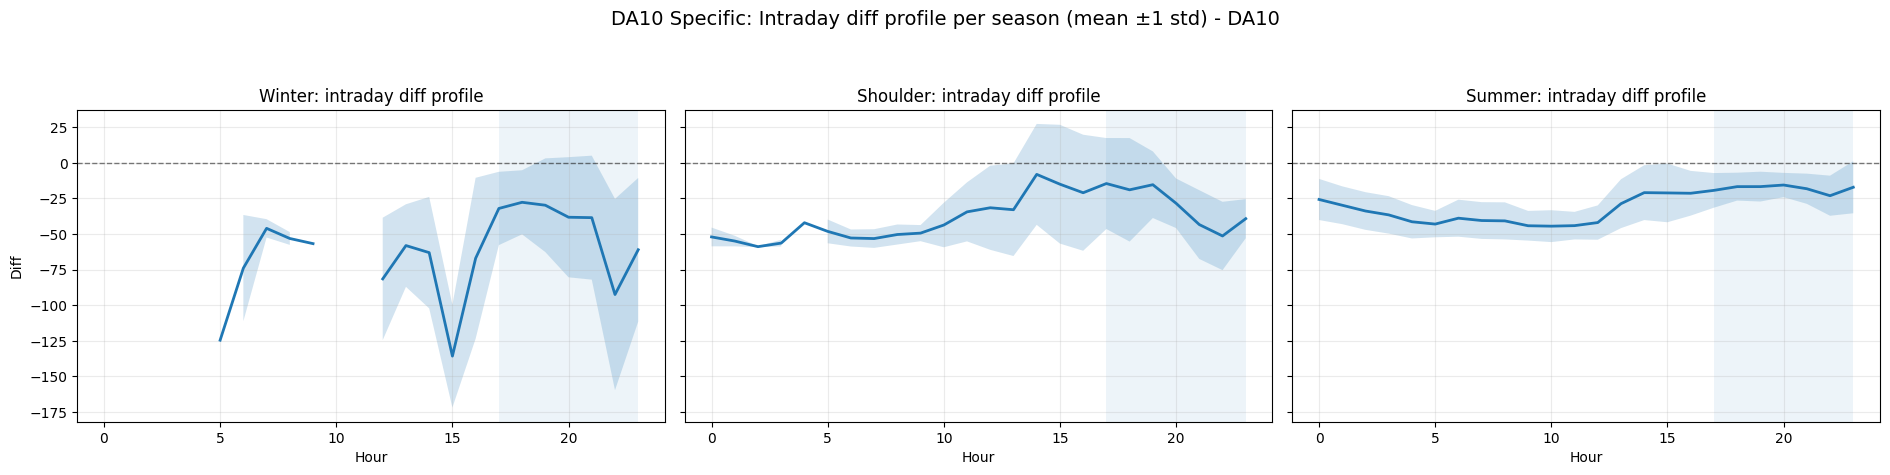

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import os

# =========================
# Intraday diff profile per season (mean ± 1 std)
#  - DA1–DA9 combined (3 panels)
#  - DA10 only (3 panels)
# =========================

# ---- CONFIG ----
PEAK_START = 17   # shaded region start hour (inclusive)
PEAK_END   = 23   # shaded region end hour (exclusive)
USE_HOUR_BUCKETS = True  # if your data is 30-min, this aggregates into hours (0..23)

# seasons by month (common in Israel power analysis)
SEASON_BY_MONTH = {
    "winter":   [12, 1, 2],
    "shoulder": [3, 4, 5, 10, 11],
    "summer":   [6, 7, 8, 9],
}

OUTDIR = "/content/outputs" # Define OUTDIR for saving plots
os.makedirs(OUTDIR, exist_ok=True)

# ---- load ----
df = out.copy()
cols = list(df.columns)

def pick_col(preferred, regex_fallback):
    for c in preferred:
        if c in df.columns:
            return c
    cand = [c for c in df.columns if re.search(regex_fallback, c, flags=re.IGNORECASE)]
    return cand[0] if cand else None

dt_col = pick_col(["DateTime", "Datetime", "date_time", "timestamp"], r"(date|time)")
bid_col = pick_col(["BidSell", "Bid", "BidSellDA"], r"\bbid")
diff_col = "diff" if "diff" in df.columns else None
smp_col = pick_col(["SMP", "Smp"], r"\bsmp\b")
bid_price_col = pick_col(["BidSellPrices", "BidSellPrice", "BidSell_Price", "ALT34"], r"(bid).*?(price)|alt34")

missing = []
if dt_col is None: missing.append("DateTime")
if bid_col is None: missing.append("BidSell")
if diff_col is None and (smp_col is None or bid_price_col is None):
    missing.append("diff OR (SMP and BidSellPrice/ALT34)")
if missing:
    raise KeyError(f"Missing required columns: {missing}. Available columns: {cols}")

print("Using columns:")
print("  DateTime:", dt_col)
print("  BidSell:", bid_col)
print("  diff:", diff_col)
if diff_col is None:
    print("  SMP:", smp_col)
    print("  BidSell/ALT price:", bid_price_col)

# ---- prep ----
df = df.copy()
df[dt_col] = pd.to_datetime(df[dt_col])

df["month"] = df[dt_col].dt.month
df["hour"]  = df[dt_col].dt.hour

# compute diff if needed
if diff_col is None:
    df[smp_col] = pd.to_numeric(df[smp_col], errors="coerce")
    df[bid_price_col] = pd.to_numeric(df[bid_price_col], errors="coerce")
    df["diff"] = df[smp_col] - df[bid_price_col]
else:
    df["diff"] = pd.to_numeric(df[diff_col], errors="coerce")

# keep only rows with bids + diff
df = df[df[bid_col].notna()].dropna(subset=["diff"]).copy()

# optional: if you have half-hour data and want hourly profile, hour already buckets 0..23.
# If you want to keep half-hour resolution, you’d need a "slot" variable (not used here).

def assign_season(m):
    for s, months in SEASON_BY_MONTH.items():
        if m in months:
            return s
    return "other"

df["season"] = df["month"].apply(assign_season)

# enforce season order
season_order = ["winter", "shoulder", "summer"]
df = df[df["season"].isin(season_order)].copy()

# ---- profile stats function ----
def intraday_stats(dsub):
    # mean/std by hour (0..23)
    g = dsub.groupby("hour")["diff"]
    prof = pd.DataFrame({"mean": g.mean(), "std": g.std()}).reset_index()
    prof = prof.sort_values("hour")

    # ensure all hours exist (0..23)
    all_hours = pd.DataFrame({"hour": np.arange(0, 24)})
    prof = all_hours.merge(prof, on="hour", how="left")
    return prof

def plot_intraday_3panels(dsub, super_title, save_path: str | None = None):
    fig, axes = plt.subplots(1, 3, figsize=(19, 4.8), sharey=True)

    for ax, season in zip(axes, season_order):
        d_sea = dsub[dsub["season"] == season]
        prof = intraday_stats(d_sea)

        ax.plot(
            prof["hour"],
            prof["mean"],
            linewidth=2
        )
        ax.fill_between(
            prof["hour"],
            prof["mean"] - prof["std"],
            prof["mean"] + prof["std"],
            alpha=0.2
        )

        # shaded peak window
        ax.axvspan(PEAK_START, PEAK_END, alpha=0.08)

        # zero reference
        ax.axhline(0, color="black", linestyle="--", linewidth=1, alpha=0.5)

        ax.set_title(f"{season.capitalize()}: intraday diff profile")
        ax.set_xlabel("Hour")
        ax.grid(True, alpha=0.25)

    axes[0].set_ylabel("Diff")

    fig.suptitle(super_title, fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.92])

    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"Plots saved to: {save_path}")

    plt.show()

# ---- split groups ----
da_1_9 = [f"DA{i}" for i in range(1, 10)]
df_1_9 = df[df[bid_col].isin(da_1_9)].copy()
df_10  = df[df[bid_col] == "DA10"].copy()

# ---- plot like screenshot ----
plot_intraday_3panels(
    df_1_9,
    "Combined: Intraday diff profile per season (mean ±1 std) - DA1-DA9 Combined",
    save_path=os.path.join(OUTDIR, "intraday_diff_DA1_9_seasonal.png")
)

plot_intraday_3panels(
    df_10,
    "DA10 Specific: Intraday diff profile per season (mean ±1 std) - DA10",
    save_path=os.path.join(OUTDIR, "intraday_diff_DA10_seasonal.png")
)